# **XGAN: Unsupervised Image-to-Image Translation for Many-to-Many Mappings**

Implementation of XGAN model for automatic cartoon generation from real faces. 

## Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import libraries

In [2]:
import math
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, pathlib 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
from torch.utils.data import DataLoader
from torch.autograd import Variable

from PIL import Image
import cv2

import time
from tqdm import tqdm
import helper

## Bring datasets forward

In [3]:
!unzip '/content/drive/My Drive/Made with ML/datasets/faces_wo_bg.zip'

Archive:  /content/drive/My Drive/Made with ML/datasets/faces_wo_bg.zip
   creating: content/images/
   creating: content/images/faces_people_wo_bg/
  inflating: content/images/faces_people_wo_bg/Jenifer_Lewis_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Kriti_Sanon_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Kim_Raver_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Adina_Porter_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/John_Ridley_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Thomas_McDonell_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Alexandra_Breckenridge_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Gloria_Swanson_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Titus_Welliver_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Kay_Francis_0_wo_bg.jpg  
  inflating: content/images/faces_people_wo_bg/Jon_Foster_0_wo_bg.jpg  
  inflating: content/images

In [4]:
!mv /content/content/images/faces_people_wo_bg /content
!rm -r /content/content

In [5]:
!unzip '/content/drive/My Drive/Made with ML/datasets/cartoonset10k_cropped.zip'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: cartoonset10k_cropped/cs10755957224249545546.png  
  inflating: cartoonset10k_cropped/cs1075609143194812341.png  
  inflating: cartoonset10k_cropped/cs10756219695542318383.png  
  inflating: cartoonset10k_cropped/cs10756288549453457405.png  
  inflating: cartoonset10k_cropped/cs10756327220067079832.png  
  inflating: cartoonset10k_cropped/cs10756991518761997041.png  
  inflating: cartoonset10k_cropped/cs10757362374146439820.png  
  inflating: cartoonset10k_cropped/cs10757675124958983592.png  
  inflating: cartoonset10k_cropped/cs10757999797523659567.png  
  inflating: cartoonset10k_cropped/cs10758021930561957001.png  
  inflating: cartoonset10k_cropped/cs10758037387654375729.png  
  inflating: cartoonset10k_cropped/cs10758444626484126733.png  
  inflating: cartoonset10k_cropped/cs10758461782154833330.png  
  inflating: cartoonset10k_cropped/cs10758567891224201740.png  
  inflating: cartoonset10k_cropped/cs1075858

## Creating train and test sets

### Faces

In [6]:
!mkdir /content/faces
!mkdir /content/faces/train
!mkdir /content/faces/train/train
!mkdir /content/faces/test
!mkdir /content/faces/test/test

In [7]:
# move faces to /content/faces_train
faces= os.listdir("/content/faces_people_wo_bg")
train = int(0.9*len(faces)) #int hace round down(float_number)
for i in range(train):
  os.rename("/content/faces_people_wo_bg/" + faces[i], "/content/faces/train/train/" + faces[i])

In [8]:
# move faces to /content/faces_test
faces = os.listdir("/content/faces_people_wo_bg")
test = int(len(faces)) 
for i in range(test):
  os.rename("/content/faces_people_wo_bg/" + faces[i], "/content/faces/test/test/" + faces[i])

In [9]:
!rm -r /content/faces_people_wo_bg

### Cartoons

In [10]:
!mkdir /content/cartoons
!mkdir /content/cartoons/train
!mkdir /content/cartoons/train/train
!mkdir /content/cartoons/test
!mkdir /content/cartoons/test/test

In [11]:
# move cartoons to /content/cartoons_train
cartoons= os.listdir("/content/cartoonset10k_cropped")
train = int(0.9*len(cartoons)) #int hace round down(float_number)
for i in range(train):
  os.rename("/content/cartoonset10k_cropped/" + cartoons[i], "/content/cartoons/train/train/" + cartoons[i])

In [12]:
# move cartoons to /content/cartoons_test
cartoons = os.listdir("/content/cartoonset10k_cropped")
test = int(len(cartoons)) 
for i in range(test):
  os.rename("/content/cartoonset10k_cropped/" + cartoons[i], "/content/cartoons/test/test/" + cartoons[i])

In [13]:
!rm -r /content/cartoonset10k_cropped

## Visualizing data

(313, 253, 3)


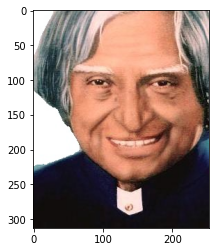

In [14]:
path_images = '/content/faces/train/train/'
img = cv2.imread(path_images + 'A_P_J_Abdul_Kalam_0_wo_bg.jpg')
print(img.shape)
plt.imshow(img)
plt.show()

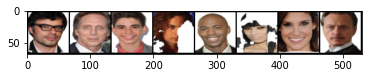

In [15]:
image_size=64
workers=4
batch_size = 8
path_images = '/content/faces/train/'

transform = T.Compose([
                T.Resize((image_size,image_size)) ,
                T.ToTensor(),
                # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                ])

dataloader_images = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(path_images, transform=transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers = workers)

dataiter = iter(dataloader_images)
images_faces = dataiter.next()

# show images
# print(images[0])
plt.imshow(torchvision.utils.make_grid(images_faces[0]).permute(1, 2, 0)[:,:,[2,1,0]])

(400, 400, 3)


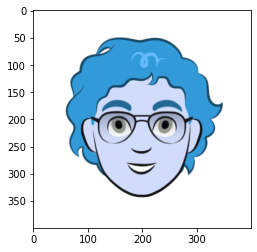

In [16]:
path_cartoons = '/content/cartoons/train/train/'

img = cv2.imread(path_cartoons + 'cs1048486361028912.png')
print(img.shape)
plt.imshow(img)

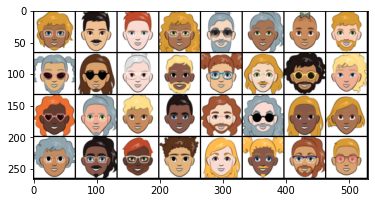

In [17]:
num_epochs = 20
batch_size = 32
learning_rate = 1e-3
image_size = 64
#variational_beta = 1
use_gpu = True
workers = 4

path_cartoons = '/content/cartoons/train/'

transform = T.Compose([
                T.CenterCrop(300),
                T.Resize((image_size,image_size)) ,
                T.ToTensor(),
                # T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                ])

dataloader_cartoons = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(path_cartoons, transform=transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers = workers)

dataiter = iter(dataloader_cartoons)
images_cartoon = dataiter.next()

# show images
#print(images[0])
plt.imshow(torchvision.utils.make_grid(images_cartoon[0]).permute(1, 2, 0))

## Dataloader

In [18]:
image_size = 64
batch_size = 32

train_dataset_faces = torchvision.datasets.ImageFolder('/content/faces/train', 
                                        transform=T.Compose([ 
                                                             T.Resize((image_size, image_size)),
                                                             T.ToTensor()
                                                             ]))

test_dataset_faces = torchvision.datasets.ImageFolder('/content/faces/test', 
                                        transform=T.Compose([
                                                             T.Resize((image_size, image_size)),
                                                             T.ToTensor()
                                                             ]))

train_dataset_cartoons = torchvision.datasets.ImageFolder('/content/cartoons/train', 
                                        transform=T.Compose([ 
                                                             T.CenterCrop(300),
                                                             T.Resize((image_size, image_size)),
                                                             T.ToTensor()
                                                             ]))

test_dataset_cartoons = torchvision.datasets.ImageFolder('/content/cartoons/test', 
                                        transform=T.Compose([
                                                             T.CenterCrop(300),
                                                             T.Resize((image_size, image_size)),
                                                             T.ToTensor()
                                                             ]))

train_loader_faces = torch.utils.data.DataLoader(train_dataset_faces, 
                                           batch_size=batch_size, shuffle=True, num_workers=4)
test_loader_faces = torch.utils.data.DataLoader(test_dataset_faces, 
                                           batch_size=batch_size, shuffle=False)

train_loader_cartoons = torch.utils.data.DataLoader(train_dataset_cartoons, 
                                           batch_size=batch_size, shuffle=True, num_workers=4)
test_loader_cartoons = torch.utils.data.DataLoader(test_dataset_cartoons, 
                                           batch_size=batch_size, shuffle=False)

## XGAN Model

### Classes

In [19]:
#selu , coursera gan
#He init
#batchNorm
#


class E1(nn.Module):
  def __init__(self):
    super(E1, self).__init__()
    #c=capacity
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1) # out: 32 x 32 x 32
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1) #out: 16 x 16 x 64

  def forward(self, x):
    x = F.relu(self.conv1(x)) #try selu
    x = F.relu(self.conv2(x))
    return x  

class E2(nn.Module):
  def __init__(self):
    super(E2, self).__init__()
    #c=capacity
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1) # out: 32 x 32 x 32
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1) #out: 16 x 16 x 64

  def forward(self, x):
    x = F.relu(self.conv1(x)) #try selu
    x = F.relu(self.conv2(x))
    return x

class Eshared(nn.Module):
  def __init__(self):
    super(Eshared, self).__init__()
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features = 4*4*256, out_features = 1024)
    self.fc2 = nn.Linear(in_features = 1024, out_features = 1024)
  
  def forward(self,x):
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    
    return x
    

class Dshared(nn.Module):
  def __init__(self):
    super(Dshared, self).__init__()
    #c = capacity
    self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2)
    self.deconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
  
  def forward(self,x):
    x = x.view(-1,1024,1,1)
    x = F.relu(self.deconv1(x))             
    x = F.relu(self.deconv2(x))
    return x

class D1(nn.Module):
  def __init__(self):
    super(D1, self).__init__()
    #c = capacity
    self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
    self.deconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
    self.deconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=2, stride=2)
  
  def forward(self,x):
    x = F.relu(self.deconv3(x))
    x = F.relu(self.deconv4(x))
    x = F.relu(self.deconv5(x))
    return x

class D2(nn.Module):
  def __init__(self):
    super(D2, self).__init__()
    #c = capacity
    self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
    self.deconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
    self.deconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=2, stride=2)
  
  def forward(self,x):
    x = F.relu(self.deconv3(x))
    x = F.relu(self.deconv4(x))
    x = F.relu(self.deconv5(x))
    return x

class Cdann(nn.Module):
  def __init__(self):
    super(Cdann, self).__init__()
    self.fc1 = nn.Linear(in_features = 1024, out_features = 512)
    self.fc2 = nn.Linear(in_features = 512 , out_features = 256)
    self.fc3 = nn.Linear(in_features = 256 , out_features = 64)
    self.fc4 = nn.Linear(in_features = 64, out_features = 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))                
    return x

# class Discriminator(nn.Module):
#   def __init__(self):
#     super(Discriminator, self).__init__()
#     self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)     #
#     self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)    #
#     self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)    #
#     self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)    #
#     self.flatten = nn.Flatten()                                                              
#     self.fc1 = nn.Linear(in_features = 4*4*32, out_features = 1)

#   def forward(self, x):
#     x = F.relu(self.conv1(x))
#     x = F.relu(self.conv2(x))
#     x = F.relu(self.conv3(x))
#     x = F.relu(self.conv4(x))
#     x = self.flatten(x)
#     x = torch.sigmoid(self.fc1(x))
#     return x

# class Xgan(nn.Module):               ##### no Ldann, Lsem, Lgann, Lteach
#   def __init__(self):
#     super(Xgan, self).__init__()
#     self.e1 = E1()
#     self.e2 = E2()
#     self.eshared = Eshared()
#     self.d1 = D1()
#     self.d2 = D2()
#     self.dshared = Dshared()
#     self.discriminator = Discriminator()
    
#   def forward(self,cartoon, face):
#     x1 = self.e1(face)
#     x2 = self.e2(cartoon)
#     ########   to be defined  ########            que es esto??? nunca lo usamos
#     x_joint = torch.tensor([0]) 
#     x_shared = self.eshared(x_joint)
#     x_dshared = self.dshared(x_shared)
#     x_face = self.d1(x_shared)
#     x_cartoon = self.d2(x_shared)
#     return x_face, x_cartoon

In [20]:
#Basic Encoder
e1 = E1()
e2 = E2()
e_shared = Eshared()
d_shared = Dshared()
d1 = D1()
d2 = D2()
#Cdann
c_dann = Cdann()
#d1_2
discriminator = Discriminator()
#teacher


## Trainning

### Optimizers, losses

In [21]:
#Lrec1
listRec1 = list(e1.parameters()) + list(e_shared.parameters()) + list(d_shared.parameters()) + list(d1.parameters())
optimizerRec1 = torch.optim.Adam(listRec1,lr=learning_rate)
#Lrec2
listRec2 = list(e2.parameters()) + list(e_shared.parameters()) + list(d_shared.parameters()) + list(d2.parameters())
optimizerRec2 = torch.optim.Adam(listRec2,lr=learning_rate)
#Ldann
listEncoder1 = list(e1.parameters()) + list(e_shared.parameters())
optimizerEnc1 = torch.optim.Adam(listEncoder1,lr=learning_rate)

listEncoder2 = list(e2.parameters()) + list(e_shared.parameters())
optimizerEnc2 = torch.optim.Adam(listEncoder2,lr=learning_rate)

optimizerCdann = torch.optim.Adam(c_dann.parameters(), lr = learning_rate)
#Lsem 
listSem12 = list(e1.parameters()) + list(e_shared.parameters()) + list(d_shared.parameters()) + list(d2.parameters()) + list(e2.parameters())
optimizerSem12 = torch.optim.Adam(listSem12, lr = learning_rate)

listSem21 = list(e2.parameters()) + list(e_shared.parameters()) + list(d_shared.parameters()) + list(d1.parameters()) + list(e1.parameters())
optimizerSem21 = torch.optim.Adam(listSem21, lr = learning_rate)
#Lgan
# listGan = list(e1.parameters()) + list(e_shared.parameters()) + list(d_shared.parameters()) + list(d2.parameters()) + list(discriminator.parameters())
# optimizerSem21 = torch.optim.Adam(listGan, lr = learning_rate)






In [22]:
criterion_bc = nn.BCELoss()

### To GPU

In [23]:
torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

In [24]:
e1.to(device)
e2.to(device)
e_shared.to(device)
d_shared.to(device)
d1.to(device)
d2.to(device)
c_dann.to(device)
discriminator.to(device)

criterion_bc.to(device) # it's a good habit

BCELoss()

### Training

In [25]:
#########################
#### hyperparameters ####
#########################
num_epochs = 20
learning_rate = 0.0001
use_gpu = True

In [ ]:
train_loss_rec1 = []
train_loss_rec2 = []
train_loss_cdan = []
train_loss_sem12 = []
train_loss_sem21 = []
for epoch in range(num_epochs):
  for faces_batch, cartoons_batch in zip(train_loader_faces, train_loader_cartoons):
    faces_batch, _ = faces_batch
    faces_batch = Variable(faces_batch.type(torch.Tensor))
    class_image = Variable(torch.ones(faces_batch.size(0)))
    faces_batch = faces_batch.to(device)
    class_image = class_image.to(device)
    
    cartoons_batch,_ = cartoons_batch
    cartoons_batch = Variable(cartoons_batch.type(torch.Tensor))
    class_cartoons = Variable(torch.zeros(cartoons_batch.size(0)))
    cartoons_batch = cartoons_batch.to(device)
    class_cartoons = class_cartoons.to(device)
    
    #reconstruction image
    e1.zero_grad()
    e2.zero_grad()
    e_shared.zero_grad()
    d_shared.zero_grad()
    d1.zero_grad()
    d2.zero_grad()

    faces_enc1 = e1(faces_batch)
    faces_encoder = e_shared(faces_enc1)
    faces_decoder = d_shared(faces_encoder)
    faces_rec = d1(faces_decoder)

    cartoons_enc2 = e2(cartoons_batch)
    cartoons_encoder = e_shared(cartoons_enc2)
    cartoons_decoder = d_shared(cartoons_encoder)
    cartoons_rec = d2(cartoons_decoder)

    loss_rec1 = F.mse_loss(faces_batch, faces_rec)
    loss_rec2 = F.mse_loss(cartoons_batch, cartoons_rec)

    loss_rec1.backward()
    loss_rec2.backward()

    optimizerRec1.step()
    optimizerRec2.step()


    #classify encoders optimizar parametros del clasificador
    c_dann.zero_grad()
    e1.zero_grad()
    e2.zero_grad()
    e_shared.zero_grad()

    faces_enc1 = e1(faces_batch).detach()
    faces_encoder = e_shared(faces_enc1).detach()

    cartoons_enc2 = e2(cartoons_batch).detach()
    cartoons_encoder = e_shared(cartoons_enc2).detach()


    class_enc1 = c_dann(faces_encoder)
    class_enc2 = c_dann(cartoons_encoder)

    error_class_image = criterion_bc(class_enc1.squeeze(),class_image)
    error_class_image.backward()
    error_class_cartoons = criterion_bc(class_enc2.squeeze(),class_cartoons)
    error_class_cartoons.backward()

    error_c_dann = error_class_image + error_class_cartoons
    optimizerCdann.step()


    #optimizar parametros del encoder (e1,e2 y eshared)
    e1.zero_grad()
    e2.zero_grad()
    e_shared.zero_grad()

    image_enc1 = e1(faces_batch)
    image_encoder = e_shared(image_enc1)

    cartoons_enc2 = e2(cartoons_batch)
    cartoons_encoder = e_shared(cartoons_enc2)

    class_enc1 = c_dann(image_encoder)
    class_enc2 = c_dann(cartoons_encoder)

    class_image.data.fill_(0)
    class_cartoons.data.fill_(1)  

    error_class_image= criterion_bc(class_enc1.squeeze(),class_image)
    error_class_image.backward()
    error_class_cartoons= criterion_bc(class_enc2.squeeze(),class_cartoons)
    error_class_cartoons.backward()
    
    optimizerEnc1.step()
    optimizerEnc2.step()

    #semantic loss 1->2: e1, e_shared, d_shared, d2, e2
    e1.zero_grad()
    e2.zero_grad()
    e_shared.zero_grad()
    d_shared.zero_grad()
    d2.zero_grad()

    face_e1 = e1(faces_batch)
    face_latent = e_shared(face_e1)
    face_recon = d_shared(face_latent)
    face_d2 = d2(face_recon)
    face_encod = e2(face_d2)

    #semantic loss 2->1: e2, e_shared, d_shared, d1, e1
    e1.zero_grad()
    e2.zero_grad()
    e_shared.zero_grad()
    d_shared.zero_grad()
    d1.zero_grad()

    cartoon_e2 = e2(cartoons_batch)
    cartoon_latent = e_shared(cartoon_e2)
    cartoon_recon = d_shared(cartoon_latent)
    cartoon_d1 = d1(cartoon_recon)
    cartoon_encod = e1(cartoon_d1)
    

    loss_sem12 = F.l1_loss(face_e1, face_encod)
    loss_sem21 = F.l1_loss(cartoon_e2, cartoon_encod)    
    
    loss_sem12.backward()
    loss_sem21.backward() 
    
    optimizerSem12.step()
    optimizerSem21.step()

    #Lgan: e1, e_shared, d_shared, d2, D

  ###########################
  ##### save best model #####
  ###########################

  train_loss_rec1.append(loss_rec1.item())
  train_loss_rec2.append(loss_rec2.item())
  train_loss_cdan.append(error_c_dann.item())
  train_loss_sem12.append(loss_sem12.item())
  train_loss_sem21.append(loss_sem21.item())
  #train_loss_gan.append(loss_gan.item())
  print('Epoch [{}/{}], Loss rec1: {:.4f}'.format(epoch+1, num_epochs, loss_rec1.item()))
  print('Epoch [{}/{}], Loss rec2: {:.4f}'.format(epoch+1, num_epochs, loss_rec2.item()))
  print('Epoch [{}/{}], Loss classifier: {:.4f}'.format(epoch+1, num_epochs, error_c_dann.item()))     
  print('Epoch [{}/{}], Loss semantic 1->2: {:.4f}'.format(epoch+1, num_epochs, loss_sem12.item()))
  print('Epoch [{}/{}], Loss semantic 2->1: {:.4f}'.format(epoch+1, num_epochs, loss_sem21.item()))
#print("El mejor val_loss se obtuvo en: {}".format(epoch_especial))


Epoch [1/20], Loss rec1: 0.0726
Epoch [1/20], Loss rec2: 0.0524
Epoch [1/20], Loss classifier: 1.3863
Epoch [1/20], Loss semantic 1->2: 0.0022
Epoch [1/20], Loss semantic 2->1: 0.0030
Epoch [2/20], Loss rec1: 0.0948
Epoch [2/20], Loss rec2: 0.0693
Epoch [2/20], Loss classifier: 1.3863
Epoch [2/20], Loss semantic 1->2: 0.0003
Epoch [2/20], Loss semantic 2->1: 0.0002
Epoch [3/20], Loss rec1: 0.0785
Epoch [3/20], Loss rec2: 0.0643
Epoch [3/20], Loss classifier: 1.3863
Epoch [3/20], Loss semantic 1->2: 0.0003
Epoch [3/20], Loss semantic 2->1: 0.0002
Epoch [4/20], Loss rec1: 0.0877
Epoch [4/20], Loss rec2: 0.0513
Epoch [4/20], Loss classifier: 1.3865
Epoch [4/20], Loss semantic 1->2: 0.0002
Epoch [4/20], Loss semantic 2->1: 0.0003
Epoch [5/20], Loss rec1: 0.0669
Epoch [5/20], Loss rec2: 0.0561
Epoch [5/20], Loss classifier: 1.3864
Epoch [5/20], Loss semantic 1->2: 0.0000
Epoch [5/20], Loss semantic 2->1: 0.0002
Epoch [6/20], Loss rec1: 0.0721
Epoch [6/20], Loss rec2: 0.0500
Epoch [6/20], Lo

In [ ]:
print(faces_batch)

NameError: ignored

### Results

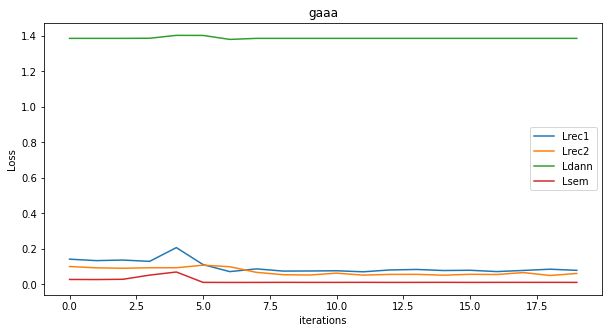

In [ ]:
plt.figure(figsize=(10,5))
plt.title("gaaa")
plt.plot(train_loss_rec1,label = "Lrec1")
plt.plot(train_loss_rec2,label = "Lrec2")
plt.show()
plt.plot(train_loss_cdan, label = "Ldann")
plt.show()
plt.plot(train_loss_sem12, label = "Lsem12")
plt.plot(train_loss_sem21, label = "Lsem21")
plt.show()
#plt.plot(train_loss_gan, label = "Lgan")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

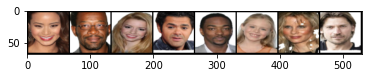

In [ ]:
plt.imshow(torchvision.utils.make_grid(images_faces[0]).permute(1, 2, 0)[:,:,[2,1,0]])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


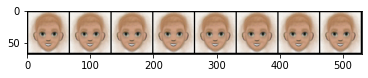

In [ ]:
with torch.no_grad():
    output = e1(images_faces[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d2(output)
  
# grid4 = torchvision.utils.make_grid(output.cpu(), nrow=1)
# plt.figure(figsize=(12, 12))
# plt.imshow(grid4.permute(1, 2, 0))



plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

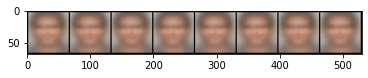

In [ ]:
with torch.no_grad():
    output = e1(images_faces[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d1(output)
  
# grid4 = torchvision.utils.make_grid(output.cpu(), nrow=1)
# plt.figure(figsize=(12, 12))
# plt.imshow(grid4.permute(1, 2, 0))



plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0)[:,:,[2,1,0]])
plt.show()

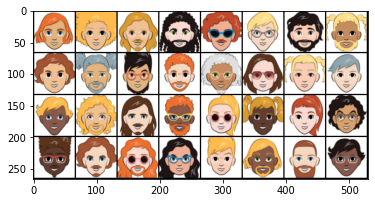

In [ ]:
plt.imshow(torchvision.utils.make_grid(images_cartoon[0]).permute(1, 2, 0))
plt.show()

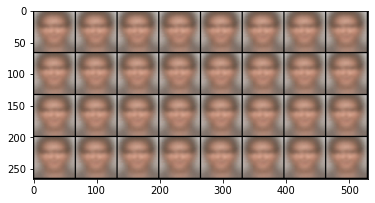

In [ ]:
with torch.no_grad():
    output = e2(images_cartoon[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d1(output)
  
# grid4 = torchvision.utils.make_grid(output.cpu(), nrow=1)
# plt.figure(figsize=(12, 12))
# plt.imshow(grid4.permute(1, 2, 0))



plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0)[:,:,[2,1,0]])
plt.show()